# Линейная регрессия и стохастический градиентный спуск

## Введение
Линейная регрессия - один из наиболее хорошо изученных методов машинного обучения, позволяющий прогнозировать значения количественного признака в виде линейной комбинации прочих признаков с параметрами - весами модели. Оптимальные (в смысле минимальности некоторого функционала ошибки) параметры линейной регрессии можно найти аналитически с помощью нормального уравнения или численно с помощью методов оптимизации.  

Линейная регрессия использует простой функционал качества - среднеквадратичную ошибку. Мы будем работать с выборкой, содержащей 3 признака. Для настройки параметров (весов) модели решается следующая задача:
$$\frac{1}{\ell}\sum_{i=1}^\ell{{(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}^2} \rightarrow \min_{w_0, w_1, w_2, w_3},$$
где $x_{i1}, x_{i2}, x_{i3}$ - значения признаков $i$-го объекта, $y_i$ - значение целевого признака $i$-го объекта, $\ell$ - число объектов в обучающей выборке.

## Градиентный спуск
Параметры $w_0, w_1, w_2, w_3$, по которым минимизируется среднеквадратичная ошибка, можно находить численно с помощью градиентного спуска.
Градиентный шаг для весов будет выглядеть следующим образом:
$$w_0 \leftarrow w_0 + \frac{2\eta}{\ell} \sum_{i=1}^\ell{{(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}}$$
$$w_j \leftarrow w_j + \frac{2\eta}{\ell} \sum_{i=1}^\ell{{x_{ij}(y_i - (w_0 + w_1x_{i1} + w_2x_{i2} +  w_3x_{i3}))}},\ j \in \{1,2,3\}$$
Здесь $\eta$ - параметр, шаг градиентного спуска.

## Стохастический градиентный спуск
У градиентного спуска, описанного выше, есть один недостаток. На больших выборках вычисление градиента по всем имеющимся данным на каждом шаге может быть вычислительно сложно. 
В стохастическом варианте градиентного спуска поправки для весов вычисляются только с учетом одного случайно взятого объекта обучающей выборки:
$$w_0 \leftarrow w_0 + \frac{2\eta}{\ell} {(y_k - (w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}))}$$
$$w_j \leftarrow w_j + \frac{2\eta}{\ell} {x_{kj}(y_k - (w_0 + w_1x_{k1} + w_2x_{k2} +  w_3x_{k3}))},\ j \in \{1,2,3\},$$
где $k$ - случайный индекс, $k \in \{1, \ldots, \ell\}$.

## Нормальное уравнение 
Нахождение вектора оптимальных весов $w$ может быть сделано и аналитически.
Мы хотим найти такой вектор весов $w$, чтобы вектор $y$, соответствующий целевому признаку, получался умножением матрицы $X$ (состоящей из всех признаков объектов обучающей выборки, кроме целевого) на вектор весов $w$. То есть, чтобы выполнялось матричное уравнение:
$$y = Xw$$
Домножением слева на $X^T$ получаем:
$$X^Ty = X^TXw$$
Это хорошо, поскольку теперь матрица $X^TX$ - квадратная, и можно найти решение (вектор $w$) в виде:
$$w = {(X^TX)}^{-1}X^Ty$$
Матрица ${(X^TX)}^{-1}X^T$ - [*псевдообратная*](https://ru.wikipedia.org/wiki/Псевдообратная_матрица) для матрицы $X$. В NumPy такую матрицу можно вычислить с помощью функции [numpy.linalg.pinv](http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.linalg.pinv.html).

Однако, нахождение псевдообратной матрицы - операция вычислительно сложная и нестабильная в случае малого определителя матрицы $X$ (проблема мультиколлинеарности). 
На практике лучше находить вектор весов $w$ решением матричного уравнения 
$$X^TXw = X^Ty$$Это может быть сделано с помощью функции [numpy.linalg.solve](http://docs.scipy.org/doc/numpy-1.10.1/reference/generated/numpy.linalg.solve.html).

Но все же на практике для больших матриц $X$ быстрее работает градиентный спуск, особенно его стохастическая версия.

## Работа с данными

**Загрузим данные из файла *advertising.csv* в объект pandas DataFrame**

In [46]:
import pandas as pd
adver_data = pd.read_csv('advertising.csv')

**Посмотрим на статистику признаков в этом наборе данных.**

In [47]:
adver_data.head()

,TV,Radio,Newspaper,Sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [48]:
adver_data.describe()

,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000
mean,147.042500,23.264000,30.554000,14.022500
std,85.854236,14.846809,21.778621,5.217457
min,0.700000,0.000000,0.300000,1.600000
25%,74.375000,9.975000,12.750000,10.375000
50%,149.750000,22.900000,25.750000,12.900000
75%,218.825000,36.525000,45.100000,17.400000
max,296.400000,49.600000,114.000000,27.000000


**Создадим NumPy массивы *X* из столбцов TV, Radio и Newspaper и *y* - из столбца Sales**

In [49]:
import numpy as np
X = np.array(adver_data.values[:,0:3])
y = np.array(adver_data.values[:,3])

**Отмасштабируем столбцы матрицы *X*, вычтя из каждого значения среднее по соответствующему столбцу и поделив результат на стандартное отклонение.**

In [50]:
means, stds = np.mean(X,axis=0), np.std(X, axis=0)

In [51]:
X = (X-means)/stds

**Добавим к матрице *X* столбец из единиц для того, чтобы не обрабатывать отдельно коэффициент $w_0$ линейной регрессии.**

In [52]:
n = np.shape(X)[0]
ones = np.reshape(np.ones(n),(n,1))

X = np.hstack((X,ones))

**Реализуем функцию *mserror* - среднеквадратичную ошибку прогноза. Она принимает два аргумента - объекты Series *y* (значения целевого признака) и *y\_pred* (предсказанные значения).**

In [53]:
def mserror(y, y_pred):
    return np.mean((y-y_pred)**2)

**Найдем среднеквадратичную ошибку прогноза значений Sales, по предсказанию значения Sales медианой исходной выборки**

In [54]:
y_med = np.median(y)
answer1 = mserror(y,y_med)
print(answer1)

28.34575


### Нормальное уравнение

**Реализуем функцию *normal_equation*, которая по заданным матрицам (массивам NumPy) *X* и *y* вычисляет вектор весов $w$ согласно нормальному уравнению линейной регрессии.**

In [55]:
def normal_equation(X, y):
    return np.linalg.solve(np.dot(X.transpose(),X),np.dot(X.transpose(),y))

In [56]:
norm_eq_weights = normal_equation(X, y)
print(norm_eq_weights)

[ 3.91925365  2.79206274 -0.02253861 14.0225    ]


**Найдем предсказание продаж с помощью найденных весов в случе средних инвестиций в рекламу по ТВ, радио и в газетах**

In [57]:
answer2 = np.sum([0., 0., 0., 1.]*norm_eq_weights)
print(answer2)

14.022500000000003


**Напишем функцию *linear_prediction*, которая принимает на вход матрицу *X* и вектор весов линейной модели *w*, а возвращает вектор прогнозов в виде линейной комбинации столбцов матрицы *X* с весами *w*.**

In [58]:
def linear_prediction(X, w):
    return np.dot(X,w)

**Найдем среднеквадратичную ошибку для модели с вектором весов, найденным с помощью нормального уравнения**

In [59]:
lin_pred = linear_prediction(X,norm_eq_weights)
answer3 = mserror(y,lin_pred)
print(answer3)

2.784126314510936


### Стохастический градиентный спуск

**Напишем функцию *stochastic_gradient_step*, реализующую шаг стохастического градиентного спуска для линейной регрессии. Функция принимает матрицу *X*, вектора *y* и *w*, число *train_ind* - индекс объекта обучающей выборки (строки матрицы *X*), по которому считается изменение весов, а также число *$\eta$* (eta) - шаг градиентного спуска (по умолчанию *eta*=0.01). Результатом будет вектор обновленных весов.**

In [60]:
def stochastic_gradient_step(X, y, w, train_ind, eta=0.01):
    return w + 2 * eta/X.shape[0] * X[train_ind] * (y[train_ind] - linear_prediction(X[train_ind], w))

**Напишем функцию *stochastic_gradient_descent*, реализующую стохастический градиентный спуск для линейной регрессии. Функция принимает на вход следующие аргументы:**
- X - матрица, соответствующая обучающей выборке
- y - вектор значений целевого признака
- w_init - вектор начальных весов модели
- eta - шаг градиентного спуска (по умолчанию 0.01)
- max_iter - максимальное число итераций градиентного спуска (по умолчанию 10000)
- max_weight_dist - минимальное евклидово расстояние между векторами весов на соседних итерациях градиентного спуска,
при котором алгоритм прекращает работу (по умолчанию 1e-8)
- seed - число, используемое для воспроизводимости сгенерированных псевдослучайных чисел (по умолчанию 42)
- verbose - флаг печати информации (например, для отладки, по умолчанию False)

**На каждой итерации в вектор (список) должно записываться текущее значение среднеквадратичной ошибки. Функция должна возвращать вектор весов $w$, а также вектор (список) ошибок.**

In [61]:
def stochastic_gradient_descent(X, y, w_init, eta=1e-2, max_iter=1e4,
                                min_weight_dist=1e-8, seed=42, verbose=False):
    # Инициализируем расстояние между векторами весов на соседних
    # итерациях большим числом. 
    weight_dist = np.inf
    # Инициализируем вектор весов
    w = w_init
    # Сюда будем записывать ошибки на каждой итерации
    errors = []
    # Счетчик итераций
    iter_num = 0
    # Будем порождать псевдослучайные числа 
    # (номер объекта, который будет менять веса), а для воспроизводимости
    # этой последовательности псевдослучайных чисел используем seed.
    np.random.seed(seed)
        
    # Основной цикл
    while weight_dist > min_weight_dist and iter_num < max_iter:
        # порождаем псевдослучайный 
        # индекс объекта обучающей выборки
        random_ind = np.random.randint(X.shape[0])
        
        w_new = stochastic_gradient_step(X, y, w, random_ind, eta)
        weight_dist = np.linalg.norm(w-w_new)
        w = w_new
        errors.append(mserror(y, linear_prediction(X, w)))
        iter_num += 1

        
    return w, errors

 **Запустим $10^5$ итераций стохастического градиентного спуска. Вектору начальных весов *w_init* присвоим нули**

In [62]:
stoch_grad_desc_weights, stoch_errors_by_iter = stochastic_gradient_descent(X, y, np.zeros(X.shape[1]),max_iter=1e5)

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ones']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Text(0, 0.5, 'MSE')

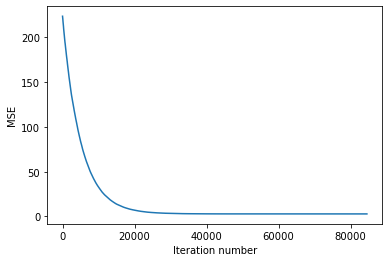

In [63]:
%pylab inline
plot(range(len(stoch_errors_by_iter)), stoch_errors_by_iter)
xlabel('Iteration number')
ylabel('MSE')

**Посмотрим на вектор весов, к которому сошелся метод.**

In [64]:
stoch_grad_desc_weights

array([ 3.91069256e+00,  2.78209808e+00, -8.10462217e-03,  1.40190566e+01])

**Посмотрим на среднеквадратичную ошибку на последней итерации.**

In [65]:
stoch_errors_by_iter[-1]

2.7844125884067044

**Найдем среднеквадратичную ошибку прогноза продаж линейной модели с вектором весов, найденных с помощью градиентного спуска**

In [66]:
answer4 = mserror(y, linear_prediction(X, stoch_grad_desc_weights))
print(answer4)

2.7844125884067044
